<b>Mushroom Data Set</b> 
(reference to UCI Machine Learning Repository <a href="https://archive.ics.uci.edu/ml/datasets/mushroom">description</a>)

In [1]:
# https://andreasondata.wordpress.com/author/andreasondata/
# http://josephwoolf.com/wp-content/uploads/2017/05/Edibility-of-a-Mushroom.pdf

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 14, 8

import numpy as np
np.set_printoptions(precision=4, threshold=10000, linewidth=100, edgeitems=999, suppress=True)

import pandas as pd
pd.set_option('display.max_columns', 30)
pd.set_option('display.width', 200)
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
pd.set_option('precision', 6)

import seaborn as sns
sns.set()

from imblearn.over_sampling import RandomOverSampler, SMOTE
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler, Normalizer
from sklearn.model_selection import cross_validate
from sklearn.model_selection import cross_val_score, KFold
from sklearn.model_selection import train_test_split
from imblearn.pipeline import Pipeline
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import ExtraTreesClassifier

from lib.utils import *
from lib.outlierdetection import *

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning) 

%load_ext watermark
%watermark -a "tb" -d -v -m -p sys,numpy,pandas,sklearn,torch,IPython
gpu_stat()

tb 2018-09-13 

CPython 3.6.4
IPython 6.2.1

sys 3.6.4 |Anaconda custom (64-bit)| (default, Jan 16 2018, 12:04:33) 
[GCC 4.2.1 Compatible Clang 4.0.1 (tags/RELEASE_401/final)]
numpy 1.14.2
pandas 0.22.0
sklearn 0.19.2
torch 0.4.0a0+9692519
IPython 6.2.1

compiler   : GCC 4.2.1 Compatible Clang 4.0.1 (tags/RELEASE_401/final)
system     : Darwin
release    : 17.5.0
machine    : x86_64
processor  : i386
CPU cores  : 24
interpreter: 64bit

GPU Name: TITAN Xp
GPU Memory: 12.0GB
CUDA Version: (9, 1, 0)
GPU Free/Total Memory: 52%


In [3]:
# Hyperparameters
HP = HYPERPARAMETERS({
    "SEED"                : 0
})

In [4]:
# Seed random generators for repro 
np.random.seed(HP.SEED)  

In [5]:
dataframe = pd.read_csv("data/agaricus-lepiota.csv", header=None)

# Read Header file
feature_names= []
with open('data/agaricus-lepiota.txt', 'r') as f_names:
    for line in f_names:
        feature_names.append(line.strip())
dataframe.columns = ['class'] + feature_names
target_names = ['edible', 'poisonous']

#Transform data form categorial to numeric
cat_variables = [i for i in dataframe.columns if dataframe[i].dtype == 'object']
encods = [LabelEncoder() for col in cat_variables]
for i, col in enumerate(cat_variables):
    dataframe[col] = encods[i].fit_transform(dataframe[col].astype(str))
    
    
X = np.float32(dataframe.values[:,1:])
y = np.int64(dataframe.values[:,0])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, shuffle=True, random_state=None)

dataset_statistics(X_train, y_train, X_test, y_test, target_names)


Dataset statistics:
number of features:       22
number of classes:        2
data type:                float32
number of train samples:  5443 (pos=2641, neg=2802, size=0MB)
number of test samples:   2681 (pos=1275, neg=1406, size=0MB)
labels                    ['edible', 'poisonous']


In [6]:
# calculate null accuracy in a single line of code
# only for binary classification problems coded as 0/1
max(np.mean(y_test.mean()), 1 - np.mean(y_test.mean()))

0.5244311823946288

In [7]:
params = {
     'bootstrap': True,
     'max_depth': 10,
     'max_features': 'auto',
     'min_samples_split': 2,
     'n_estimators': 8
}


pipeline = Pipeline(steps=[
              ('scaler',     StandardScaler(copy=True, with_mean=True, with_std=True)),
              ('sampler',    SMOTE(ratio='auto', random_state=HP.SEED)),
              ('classifier', ExtraTreesClassifier(**params))
])

scoring = 'f1'

pipeline, params

(Pipeline(memory=None,
      steps=[('scaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('sampler', SMOTE(k=None, k_neighbors=5, kind='regular', m=None, m_neighbors=10, n_jobs=1,
    out_step=0.5, random_state=0, ratio='auto', svm_estimator=None)), ('classifier', ExtraTreesClassifier(bootstrap=True, class_weigh...stimators=8, n_jobs=1,
            oob_score=False, random_state=None, verbose=0, warm_start=False))]),
 {'bootstrap': True,
  'max_depth': 10,
  'max_features': 'auto',
  'min_samples_split': 2,
  'n_estimators': 8})

<module 'matplotlib.pyplot' from '/anaconda3/lib/python3.6/site-packages/matplotlib/pyplot.py'>

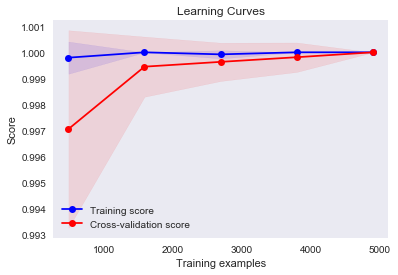

In [8]:
cv = KFold(n_splits=10, shuffle=True, random_state=HP.SEED).split(X_train)
plot_learning_curve(pipeline, 'Learning Curves', X_train, y_train, 
                    cv=cv, scoring=scoring, shuffle=True, random_state=HP.SEED)

In [9]:
# http://www.ritchieng.com/machine-learning-evaluate-classification-model/
# https://github.com/justmarkham/DAT8/blob/master/other/model_evaluation_comparison.md\

# Accuracy of a model that simply counts, i.e. looks at the prior distribution
y_pred = pipeline.fit(X_train, y_train).predict(X_test)
y_prob = pipeline.predict_proba(X_test)

print('Confusion Matrix\n', metrics.confusion_matrix(y_test, y_pred))  # Confusion Matrix
print('Accuracy ', metrics.accuracy_score(y_test, y_pred))            # Accuracy (TP + TN) / float(TP + TN + FP + FN)
print('Recall   ', metrics.recall_score(y_test, y_pred))                # Recall (Sensitivity)   TP / float(FN + TP)
print('Precision', metrics.precision_score(y_test, y_pred))     
print('F1       ', metrics.f1_score(y_test, y_pred))     
print('ROC AUC  ', metrics.roc_auc_score(y_test, y_pred))     

Confusion Matrix
 [[1406    0]
 [   0 1275]]
Accuracy  1.0
Recall    1.0
Precision 1.0
F1        1.0
ROC AUC   1.0


In [10]:
#  Cross-validate score on test set
cv = KFold(n_splits=10, shuffle=True, random_state=HP.SEED).split(X_test)
scores = cross_val_score(pipeline, X_test, y_test, cv=cv,  scoring="accuracy",  verbose=0, n_jobs=-1)

print("Test accuracy score:", np.mean(scores), np.std(scores))

Test accuracy score: 0.9992537313432835 0.001492537313432818


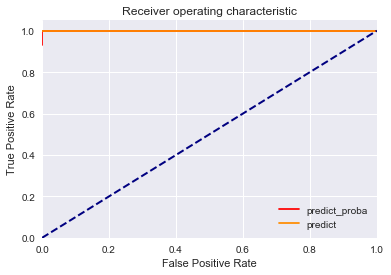

In [11]:
plot_roc_curve(y_test, y_pred, y_prob)

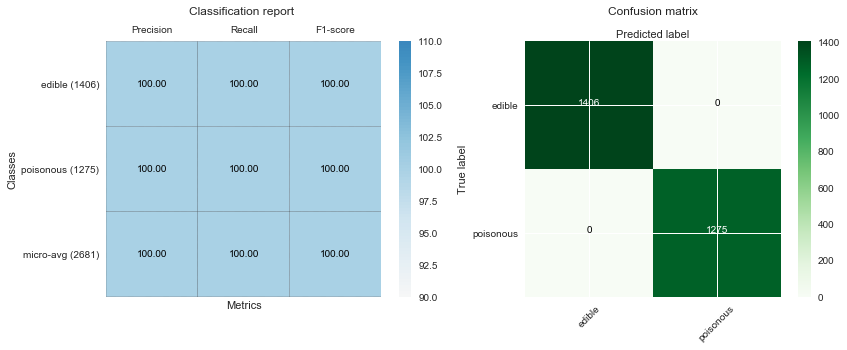

In [12]:
plot_classifier_summary(y_test, y_pred, target_names)

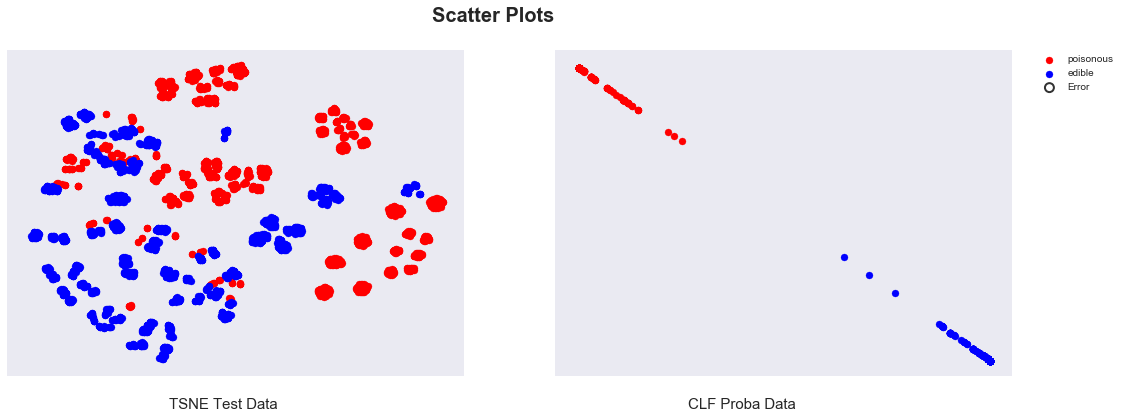

In [13]:
plot_scatter_plots(X_test, y_pred, y_prob, y_test, target_names, figsize=(18,6))

In [14]:
# Check classification of full data set
classifier_summary_report(X, y, pipeline.predict(X), target_names)

Note: weighted average f1-score 
              precision    recall  f1-score   support

     edible       1.00      1.00      1.00      4208
  poisonous       1.00      1.00      1.00      3916

avg / total       1.00      1.00      1.00      8124



'Data points=8124'

'Features=22'

'Class dist.=0.482029'

'F1 valid=1.000000'

'ACC=1.000000'

'ROC_AUC=1.000000'

'LOG_LOSS=0.000000'

'Misclassified=0'

'Data points=[]'